# INFERÊNCIA DE STATUS DE ENTREGA DE AVISOS DE RECEBIMENTO UTILIZANDO REDES NEURAIS CONVOLUCIONAIS

Esse script foi utilizado como parte de trabalho  de  conclusao de curso apresentado ao curso de especializacãoo em Ciência de Dados e BigData como requisito parcial à obtencão do título de especialista.

O presente trabalho teve como base o artigo de Sunita Nayak publicado em 29 de  maio de 2019

https://www.learnopencv.com/image-classification-using-transfer-learning-in-pytorch/

In [3]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [4]:
from torchvision.transforms.functional import crop

def bottom_crop(image):
    return crop(image, 2*image_size/3, 2*image_size/3, image_size, image_size)

In [5]:
image_size = 512

# Transformando as imagens
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(size=image_size),
        transforms.Lambda(bottom_crop),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(size=image_size),
        transforms.Lambda(bottom_crop),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=image_size),
        transforms.Lambda(bottom_crop),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [6]:
# Carregar as imagens

# Determinar as pastas de treino, validação e teste

dataset = r'C:\Users\leon\OneDrive\academico\pos puc-minas\tcc\script\data\split'

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'validation')

# Tamanho do batch de treinamento
bs = 32

# Determinando o número de classes
num_classes = len(os.listdir(valid_directory))  
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'validation': datasets.ImageFolder(root=valid_directory, transform=image_transforms['validation'])
}

# Mapear os índices com os nomes das classes (entregue e devolvido)
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Quantidad de imagens para serem utilizados para calcular erro médio e acurácia
train_data_size = len(data['train'])
valid_data_size = len(data['validation'])

# Cria os DataLoaders para treino e validação
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['validation'], batch_size=bs, shuffle=True)

2
{0: 'devolvidos', 1: 'entregues'}


In [7]:
train_data_size, valid_data_size

(1144, 144)

In [8]:
alexnet = models.alexnet(pretrained=True)
alexnet

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\leon/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100.0%


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
# Congelar os parametros da rede pré-treinada
for param in alexnet.parameters():
    param.requires_grad = False

In [10]:
# Mudar a última camada para alterar o número de classes
alexnet.classifier[6] = nn.Linear(4096, num_classes)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet.cuda()
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
device

device(type='cuda', index=0)

In [13]:
summary(alexnet, (3, image_size, image_size), device='cuda')

f:\leon\venvs\puc-minas\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 127, 127]          23,296
              ReLU-2         [-1, 64, 127, 127]               0
         MaxPool2d-3           [-1, 64, 63, 63]               0
            Conv2d-4          [-1, 192, 63, 63]         307,392
              ReLU-5          [-1, 192, 63, 63]               0
         MaxPool2d-6          [-1, 192, 31, 31]               0
            Conv2d-7          [-1, 384, 31, 31]         663,936
              ReLU-8          [-1, 384, 31, 31]               0
            Conv2d-9          [-1, 256, 31, 31]         884,992
             ReLU-10          [-1, 256, 31, 31]               0
           Conv2d-11          [-1, 256, 31, 31]         590,080
             ReLU-12          [-1, 256, 31, 31]               0
        MaxPool2d-13          [-1, 256, 15, 15]               0
AdaptiveAvgPool2d-14            [-1, 25

In [14]:
# Definição de algoritmo de otimização de gradiente descendente e função de erro
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

In [19]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Função para treinamento e validação
    Parâmetros
        :param model: modelo para treinar e validar
        :param loss_criterion: critério de erro para minização
        :param optimizer: otimizador para calcular os gradientes
        :param epochs: número de épocas (default=25)
  
    Retorna
        model: modelo treinado com a melhor acurácia na validação
        history: (dicionário): histórico com erro no treinamento, erro na validação e acurácia
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Limpar gradientes
            optimizer.zero_grad()
            
            # Forward pass - calcular saídas a partir das entradas utilizando o modelo
            outputs = model(inputs)
            
            # Calcular erro
            loss = loss_criterion(outputs, labels)
            
            # Realizar backpropagation 
            loss.backward()
            
            # Atualizar os parâmetros
            optimizer.step()
            
            # Calcular o erro total para esse lote (batch) e somar o erro no treino
            train_loss += loss.item() * inputs.size(0)
            
            # Calcula a acurácia
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Converter os acertos para float e calcular a acurácia média
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Calcular a acurácia total de treino do lote todo e adicionar a em train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validação - não é necessário rastrear os gradientes, pois o modelo não vai ser treinado com a validação
        with torch.no_grad():

            # Mudando de treino para validação
            model.eval()

            # Iteração de validação
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass de validação
                outputs = model(inputs)

                # Calcular erro de validação
                loss = loss_criterion(outputs, labels)

                # Calcular erro de validação e adicionar a valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calcular a acurácia de validação
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Converter os acertos para float e calcular a acurácia média
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Calcular a acurácia total de validação do lote todo e adicionar a em train_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Calcular a média de erro e acurácia no treino
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Calcular a média de erro e acurácia na validação
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        # Incluir no histórico
        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        if avg_valid_acc > best_acc:
            best_acc = avg_valid_acc
            torch.save(model, './modelos/modelo_'+str(epoch)+'.pt')
            
    return model, history

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 50
trained_model, history = train_and_validate(alexnet, loss_func, optimizer, num_epochs)

#torch.save(history, dataset+'_history_3.pt')

Epoch: 1/50
Epoch : 001, Training: Loss: 0.3561, Accuracy: 84.6154%, 
		Validation : Loss : 0.4106, Accuracy: 81.2500%, Time: 35.3481s
Epoch: 2/50
Epoch : 002, Training: Loss: 0.3640, Accuracy: 84.0909%, 
		Validation : Loss : 0.3417, Accuracy: 84.0278%, Time: 34.9824s
Epoch: 3/50
Epoch : 003, Training: Loss: 0.3639, Accuracy: 83.5664%, 
		Validation : Loss : 0.3480, Accuracy: 84.7222%, Time: 34.9457s
Epoch: 4/50
Epoch : 004, Training: Loss: 0.3602, Accuracy: 83.9161%, 
		Validation : Loss : 0.3495, Accuracy: 83.3333%, Time: 35.2868s
Epoch: 5/50
Epoch : 005, Training: Loss: 0.3401, Accuracy: 84.4406%, 
		Validation : Loss : 0.3679, Accuracy: 82.6389%, Time: 34.5301s
Epoch: 6/50
Epoch : 006, Training: Loss: 0.3640, Accuracy: 83.6538%, 
		Validation : Loss : 0.3557, Accuracy: 83.3333%, Time: 34.2551s
Epoch: 7/50
Epoch : 007, Training: Loss: 0.3982, Accuracy: 82.6049%, 
		Validation : Loss : 0.3237, Accuracy: 88.1944%, Time: 34.4401s
Epoch: 8/50
Epoch : 008, Training: Loss: 0.3704, Accura

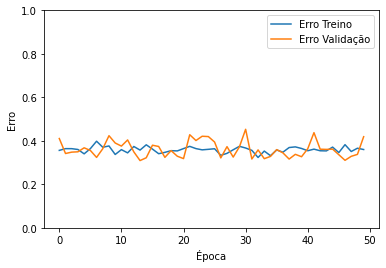

In [24]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Erro Treino', 'Erro Validação'])
plt.xlabel('Época')
plt.ylabel('Erro')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()

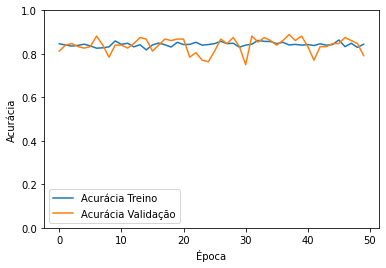

In [25]:
plt.plot(history[:,2:4])
plt.legend(['Acurácia Treino', 'Acurácia Validação'])
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [26]:
melhor_modelo = torch.load('./modelos/modelo_37.pt')
melhor_modelo

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [60]:
def predict(model, test_image_name):
    '''
    Função para realizar a predição do status do AR
    Parâmetros
        :param model: modelo para testar
        :param test_image_name: imagem teste
    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    #plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, image_size, image_size).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, image_size, image_size)
    
    predict_dict = dict()
    
    with torch.no_grad():
        model.eval()
        # Modelo retorna as probabilidades em log
        out = model(test_image_tensor)
        
        # Exp para voltar a probabilidade de log
        ps = torch.exp(out)
        topk, topclass = ps.topk(2, dim=1)
        for i in range(2):
            #print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])
            predict_dict[idx_to_class[topclass.cpu().numpy()[0][i]]] = topk.cpu().numpy()[0][i]
    
    return predict_dict

In [61]:
test_folder = dataset + r'\test'

In [64]:
def test_accuracy(model, test_folder):
    classes = os.listdir(test_folder)
    #print(classes)
    
    correct_predictions = 0
    wrong_predictions = 0
    
    for cl in classes:
        cl1_files = os.listdir(os.path.join(test_folder, cl))
        
        for image in cl1_files:
            full_path_image = os.path.join(test_folder, cl, image)
            p = predict(model, full_path_image)
            predicted_class = max(p, key=lambda key: p[key])
            #print(predicted_class)
            
            if predicted_class == cl:
                correct_predictions += 1
            else:
                wrong_predictions += 1
                #print(f'predicted {predicted_class} - ground true {cl} - image {full_path_image}')
    
    return correct_predictions / (correct_predictions + wrong_predictions)


In [65]:
test_acc = test_accuracy(melhor_modelo, test_folder)
test_acc

0.8888888888888888